# Machine Learning Model

In [ ]:
!pip install xlrd==2.0.1

In [1]:
# Import necessary libraries
import pandas as pd
import os
import zipfile
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Extract and Load Data
zip_file_path = 'Give Me Some Credit.zip'
extract_folder = 'give_me_some_credit_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

train_data = pd.read_csv(os.path.join(extract_folder, 'cs-training.csv'))
test_data = pd.read_csv(os.path.join(extract_folder, 'cs-test.csv'))

# Step 2: Data Inspection
print("Training Data Overview:")
print(train_data.head())
print("\nData Summary:")
print(train_data.describe())

# Check for missing values
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())

Training Data Overview:
   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                            

In [4]:
# Step 3: Data Preprocessing

# Impute missing values for MonthlyIncome (median) and NumberOfDependents (0)
imputer_income = SimpleImputer(strategy="median")
train_data['MonthlyIncome'] = imputer_income.fit_transform(train_data[['MonthlyIncome']])
train_data['NumberOfDependents'].fillna(0, inplace=True)

# Treat age outliers by capping at a minimum of 18
train_data['age'] = train_data['age'].apply(lambda x: max(x, 18))

# Drop unnecessary columns (index column)
X = train_data.drop(columns=['SeriousDlqin2yrs', 'Unnamed: 0'])
y = train_data['SeriousDlqin2yrs']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\milto\AppData\Local\Temp\ipykernel_2404\2696810298.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['NumberOfDependents'].fillna(0, inplace=True)


In [5]:
# Step 4: Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [6]:
# Step 5: Model Training with Hyperparameter Tuning

# Define the model and parameters for tuning
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10]
}

# GridSearch for the best parameters
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}



Evaluation Metrics:
Accuracy: 0.9392
AUC Score: 0.8630

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28044
           1       0.61      0.18      0.28      1956

    accuracy                           0.94     30000
   macro avg       0.78      0.59      0.63     30000
weighted avg       0.92      0.94      0.92     30000



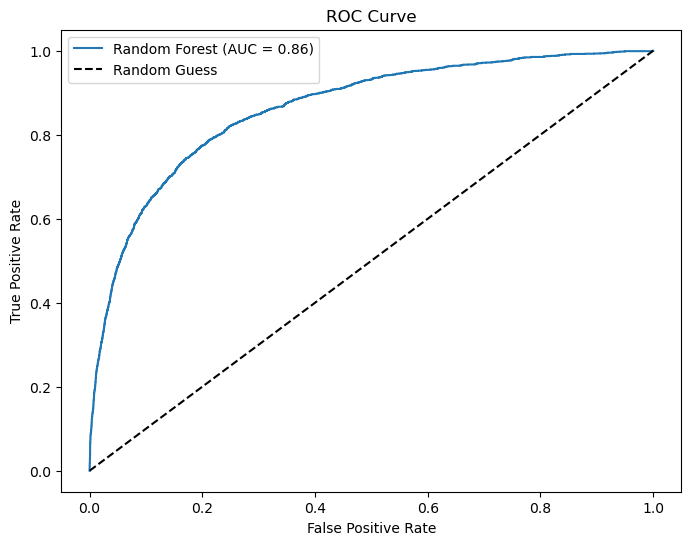

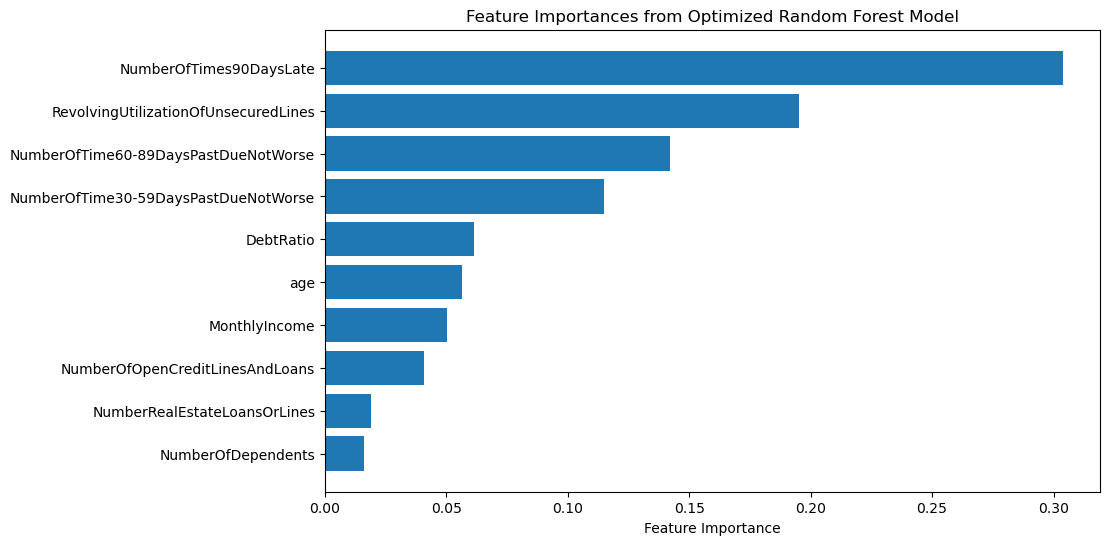

In [7]:
# Step 6: Model Evaluation

# Predict and evaluate on the validation set
y_pred = best_rf_model.predict(X_val)
y_pred_proba = best_rf_model.predict_proba(X_val)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
auc_score = roc_auc_score(y_val, y_pred_proba)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Plot ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature Importance
feature_importances = best_rf_model.feature_importances_
features = X.columns
sorted_indices = feature_importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_indices], feature_importances[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Feature Importances from Optimized Random Forest Model")
plt.show()

In [ ]:
# https://www.kaggle.com/datasets/brycecf/give-me-some-credit-dataset

In [ ]:
# Imputation with SimpleImputer: This uses SimpleImputer for MonthlyIncome to handle missing values more cleanly.
# Outlier Treatment for Age: Capping minimum age at 18 to remove outliers that may affect the model.
# Hyperparameter Tuning with GridSearchCV: Optimizes model parameters (n_estimators, max_depth, min_samples_split) to improve model performance.
# ROC Curve Plot: Visualizes the ROC curve to better understand model performance.
# Classification Report: Provides precision, recall, and F1-score for a more comprehensive view of performance.
# Enhanced Feature Importance Plot: Shows which features are most significant, potentially guiding further feature engineering or dimensionality reduction.